# **Computer Vision**

실습 목표

1. Computer Vision 문제 및 간단한 **Semantic Segmentation** 예시
2. **Torchvision**을 이용한 Computer Vision
3. **Neural Style Transfer**

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm 

import torchvision.transforms as transforms
import torchvision.models as models

from google.colab.patches import cv2_imshow
import cv2

##**1.Computer Vision 문제 및 간단한 Semantic Segmentation 예시**
- Computer vision 분야의 가장 대표적인 문제는 Object Detection과 Semantic Segmentation이다.
  - Computer vision 기술들은 자율 주행, 얼굴 인식, 의료 영상 분야 등 다양한 분야에 활용된다. 

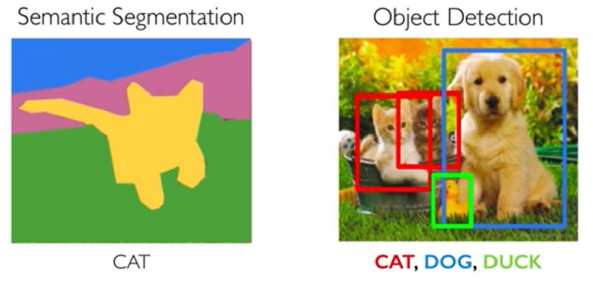

- Object Detection은 주어진 이미지에서 물체가 위치한 영역을 나타내는 bounding box를 찾는 기술이다.
  - Detection을 위한 CNN 구조에는 R-CNN, Fast R-CNN, Faster R-CNN, Mask R-CNN, YOLO 등이 있다.
- Semantic Segmentation은 주어진 이미지에서 각 픽셀이 속한 class를 구분하는 기술이다.
  - Segmentation을 위한 CNN 구조에는 Fully Convolutional Network (FCN), U-Net,Deeplab (v2, v3, v3+) 등이 있다. 
- 이번 실습에서는 FCN을 활용한 간단한 semantic segmentation을 수행해보도록 한다.
  - FCN은 데이터 입력부터 최종 추론까지 모두 convolutional layer만을 사용하는 구조이다.
  - 주어진 이미지에서 고양이가 위치한 영역을 찾아내는 segmentation을 수행한다. 

### 1.1 데이터셋 및 사전학습된 CNN 불러오기 

실험에서 사용할 고양이 segmentation 데이터셋을 다운로드한다. 

In [2]:
!pip install gdown
!gdown --id 1e_KUiS3zFaDri3VU1CQ5RTYOzuFVJ8P7
!tar -xf cat.tar
!rm -f cat.tar
print('Dataset Successfully Downloaded')

Downloading...
From: https://drive.google.com/uc?id=1e_KUiS3zFaDri3VU1CQ5RTYOzuFVJ8P7
To: /content/cat.tar
120MB [00:00, 180MB/s] 
Dataset Successfully Downloaded


다운 받은 고양이 segmentation 데이터셋을 학습에 사용할 수 있도록 `VOC_simple` 클래스를 선언한다.
- pytorch의 `dataloader`를 이용하기 위해서는 `torch.utils.data.Dataset` 클래스를 상속한 클래스의 선언이 필요하다.
- 클래스 내에 `__init__`, `__getitem__`, `__len__`의 3개의 메소드를 선언하여 오버라이드한다.


In [3]:
import os
from PIL import Image

class VOC_simple(torch.utils.data.Dataset):
    def __init__(self, dataset_root, train=True, transform=None, target_transform=None):
    # 데이터의 위치를 확인하여 목록을 획득하고, 데이터의 전처리 방식을 지정한다.  
        super(VOC_simple, self).__init__()
        self.dataset_root = dataset_root
        self.train = train
        self.transform=transform # 데이터(이미지)의 전처리
        self.target_transform=target_transform #레이블의 전처리 
        if self.train:
            self.image_root = self.dataset_root + 'train/origin/'
            self.label_root = self.dataset_root + 'train/groundtruth/'
            self.image_list = os.listdir(self.image_root) # 이미지가 위치한 폴더로부터 이미지의 목록을 획득한다.
        else:
            self.image_root = self.dataset_root + 'test/origin/'
            self.label_root = self.dataset_root + 'test/groundtruth/'
            self.image_list = os.listdir(self.image_root)# 이미지가 위치한 폴더로부터 이미지의 목록을 획득한다.

    def __getitem__(self, index):
    # 특정한 index에 대응하는 데이터와 레이블을 반환한다. 
        filename = self.image_list[index] # 이미지와 레이블의 파일 명을 확인
        filename_label = filename[:-4]+'.png'
        image = Image.open(self.image_root + filename) # 확인한 파일로부터 이미지와 레이블을 불러온다.
        target = Image.open(self.label_root + filename_label)
        target = target.convert("L") #이번 task에서 레이블은 Grayscale 이미지이므로, 불러온 이미지를 convert한다. 
        image_original = image
        if self.transform is not None and self.target_transform is not None: # 전처리 방식이 지정되어 있을 경우 적절한 전처리를 수행한다. 
            image = self.transform(image)
            target = self.target_transform(target)
            image_original = self.target_transform(image_original)
        return image_original, image, target.squeeze()

    def __len__(self):
    # 데이터의 개수를 반환한다. 
        return len(self.image_list)


Batch size와 적절한 전처리를 위한 transformation을 지정한다. 
- Semantic Segmentation의 경우, target 또한 이미지이기 때문에 적절한 크기 조절이 필요하다.
- Target의 경우 여러개의 grayscale 이미지를 stack한 형태이므로, target을 위한 transform을 별도로 선언한다.
- 이미지의 경우, Vision task에서 가장 자주 활용되는 ImageNet의 mean과 standard deviation을 활용해 normalize한다.

In [4]:
batchsize=8
transform = transforms.Compose([
    transforms.Resize((256,256)), # 크기 변경
    transforms.ToTensor(), # PIL Image를 Tensor로 변경 
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # Normalize
])

target_transform = transforms.Compose([
    transforms.Resize((256,256)),# 크기 변경
    transforms.ToTensor() # PIL Image를 Tensor로 변경
]) #RGB 이미지가 아니므로, normalization을 사용하지 않는다. 

trainset = VOC_simple(dataset_root='', train=True, transform=transform, target_transform=target_transform)
testset = VOC_simple(dataset_root='', train=False, transform=transform, target_transform=target_transform) # Training dataset과 Test dataset을 선언한다.

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size=batchsize, shuffle=False, num_workers=2) # Training dataset과 Test dataset을 불러올 loader를 선언한다.

Semantic Segmentation에서는 일반적으로 이미지의 특성 추출 (Feature Extraction)을 위해 ImageNet에서 사전학습된 신경망을 이용한다.
  - Pytorch에서 제공하는 사전학습된 ResNet 구조를 활용하기 위하여, pytorch의 torchvision에서 구성한 것과 동일한 형태와 동일한 변수명을 이용해 convolution layer와 residual block을 선언한다. 
  - 3x3 convolution layer에서 Receptive field (Feature의 한 픽셀을 계산하는데 이용된 input data의 영역)의 크기를 넓히기 위하여 dilated convolution을 사용한다. 
  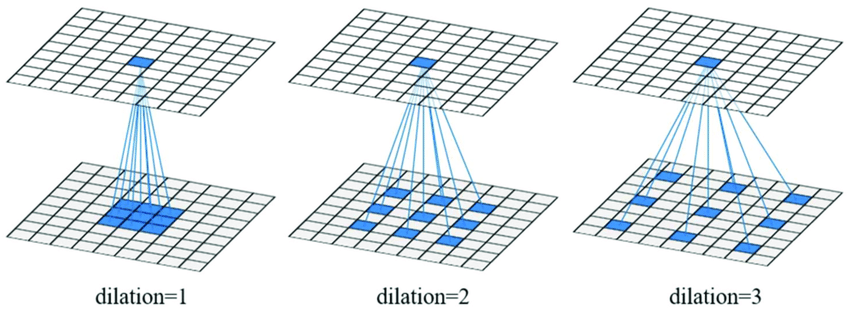
[[그림 출처]](https://www.researchgate.net/figure/An-illustration-of-the-receptive-field-for-one-dilated-convolution-with-different_fig1_336002670)


In [5]:
def conv1x1(in_planes, out_planes, stride=1): # 1x1 convolution layer
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def conv3x3(in_planes, out_planes, stride=1, dilation=1): # 3x3 convolution layer with dilation 
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, bias=False, dilation=dilation)


class Bottleneck(nn.Module): # ResNet 34 이상의 residual network를 정의하기 위한 Bottleneck block. 1x1 convolution과 3x3 convolution을 혼합하여 복잡도를 낮춘다. 
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride,  dilation)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out



위에서 정의된 Bottleneck block을 이용해 pytorch의 torchvision에서 제공되는 것과 유사한 형태로 ResNet-50 신경망을 선언하고, ImageNet 데이터셋을 이용해 사전학습된 파라미터를 불러온다 


In [6]:
from torch.utils.model_zoo import load_url as load_state_dict_from_url

class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.dilation = 1
            
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False) # 1개의 convolution layer가 축적된다.
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0]) # ResNet 50의 경우, layers[0]이 3이므로 9개의 convolution layer가 축적된다.
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=False) # ResNet 50의 경우, layers[1]이 4이므로 12개의 convolution layer가 축적된다.
        #Receptive Field를 넓히면서 feature의 크기를 줄이지 않기 위해 stride를 대신해 dilation을 사용한다. 
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=True) # ResNet 50의 경우, layers[2]이 6이므로 18개의 convolution layer가 축적된다.
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=True) # ResNet 50의 경우, layers[3]이 3이므로 9개의 convolution layer가 축적된다.
        # Classification을 위한 ResNet 50의 경우, 최종 분류를 위한 Linear layer가 하나 더 추가되어 총 50개의 layer를 사용한다. 
        # 이 task에서는 ResNet을 feature extractor로 활용하므로, linear layer를 정의하지 않는다. 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
              
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=self.dilation))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


def resnet50(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
      pretrain_dict = load_state_dict_from_url('https://download.pytorch.org/models/resnet50-19c8e357.pth', progress=True) #사전학습된 ResNet 50을 불러온다. 
      state_dict = model.state_dict()
      model_dict = {}
      for k, v in pretrain_dict.items(): # 불러온 ResNet 50에서 사용하지 않는 linear layer를 제외한 파라미터들을 로드한다. 
        if k in state_dict:
          model_dict[k] = v
      model.load_state_dict(model_dict)
    return model

### 1.2 Segmentation을 위한 Fully-Convolutional Network (FCN) 정의하기 

Fully-Convolutional Network (FCN)은 데이터 입력부터 추론까지 모두 Convolutional layer로 구성된 semantic segmentation 알고리즘이다.
  - FCN은 Encoder-Decoder 구조를 따르며, Encoder와 Decoder 모두 CNN 모델로 구성되어 있다.
  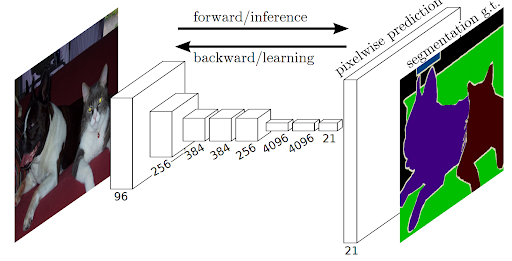 [[그림 출처]](https://arxiv.org/pdf/1411.4038.pdf)
  - 이번 실험에서 사용할 FCN에서 Encoder는 ResNet 50 구조를 활용하며, 사전학습된 ResNet 50의 파라미터로 Encoder의 파라미터를 초기화한다. 
  - ResNet Encoder로부터 추출된 feature를 이용해 segmentation mask를 추론하기 위한 Decoder를 CNN의 형태로 선언한다. 

In [7]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Decoder, self).__init__()
        inter_channels = in_channels // 4
        self.last_conv = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                       nn.BatchNorm2d(inter_channels),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(inter_channels, num_classes, 1)
                                       ) # 2개의 convolution layer를 갖는 CNN으로 decoder를 선언한다. 
        self._init_weight()

    def forward(self, x):
        x = self.last_conv(x)
        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


전체 FCN 모델은 위에서 선언한 ResNet 50과 Decoder CNN을 이용해 선언한다.

In [8]:
class FCN(nn.Module):
    def __init__(self, device):
        """
        Args
            nb_class_train (int): number of classes in a training episode
            nb_class_test (int): number of classes in a test episode
            input_size (int): dimension of input vector
            dimension (int) : dimension of embedding space
            n_shot (int) : number of shots
        """
        super(FCN, self).__init__()
        # Encoder와 Decoder를 선언한다. 
        self.encoder = resnet50(pretrained=True)
        self.decoder = Decoder(2048, 2)
        self.device = device
        self.encoder.to(self.device)
        self.decoder.to(self.device)

    def train(self): # FCN 모델을 학습 모드로 전환하기 위한 메소드를 정의한다. 
        self.encoder.train()
        self.decoder.train()

    def eval(self): # FCN 모델을 평가 모드로 전환하기 위한 메소드를 정의한다. 
        self.encoder.eval()
        self.decoder.eval()

    def forward(self,images): # FCN 모델의 추론을 수행하기 위한 메소드를 정의한다. 
        feature = self.encoder(images)
        dec_key = self.decoder(feature)
        dec_image = F.interpolate(dec_key, size=images.size()[2:4], mode='bilinear', align_corners=True)

        return dec_image

### 1.3 FCN 모델 학습 및 성능 평가

추론한 segmentation mask의 정확도를 추정하기 위하여 추론 결과의 **True Positive, False Positive, True Negative, False Negative** 값을 출력하기 위한 함수를 선언한다. 
- Semantic segmentation에서는 이전의 분류 문제와 달리 정확도(accuracy)로 성능 판별이 불가능하다.
- 따라서 segmentation의 성능 평가를 위해서 새로운 지표인 mean Intersection-over-Union (mIoU) 지표를 사용한다.

 $\text{mIoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}=\frac{\textit{True Positive}}{\textit{True Positive} + \textit{False Positive} + \textit{False Negative}}$

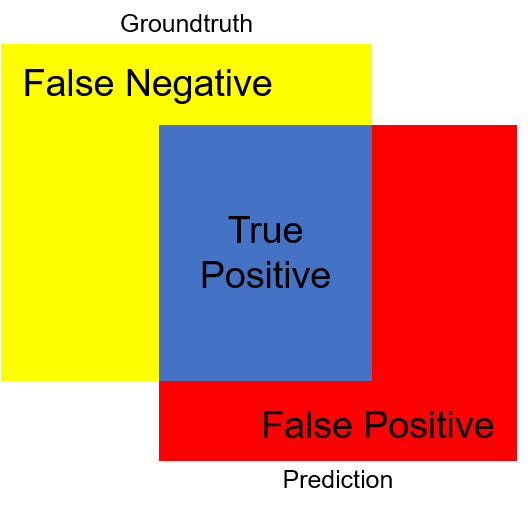

In [9]:
def compute_precision (target, dec_image):
    batchsize = target.shape[0]
    y_pred = dec_image.long().view(batchsize, -1)
    y_true = target.long().view(batchsize, -1)
    tp = (y_pred & y_true).float().sum() # 추론과 정답이 모두 true인 픽셀의 개수를 계산한다. 
    fp = (y_pred & (1 - y_true)).float().sum() # 추론은 true이나 정답은 false인 픽셀의 개수를 계산한다. 
    tn = ((1 - y_pred) & (1 - y_true)).float().sum() # 추론과 정답이 모두 false인 픽셀의 개수를 계산한다.
    fn = ((1 - y_pred) & y_true).float().sum() # 추론은 false이나 정답은 true인 픽셀의 개수를 계산한다. 
    return tp, fp, tn, fn


FCN 모델의 학습을 위해 Adam optimizer를 활용한다. 

In [10]:
fcn_model = FCN(device="cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([{'params':fcn_model.encoder.parameters(),'lr':1e-4}, {'params':fcn_model.decoder.parameters(),'lr':1e-3}])
for epoch in tqdm(range(10)):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        _, images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        optimizer.zero_grad()

        outputs = fcn_model(images)
        loss = criterion(input=outputs, target=labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print('Loss: %.3f'%(running_loss/50))
    
print('FCN Training Finished')


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


 10%|█         | 1/10 [00:57<08:37, 57.52s/it]

Loss: 0.837


 20%|██        | 2/10 [01:59<07:51, 58.97s/it]

Loss: 0.325


 30%|███       | 3/10 [03:01<06:57, 59.71s/it]

Loss: 0.233


 40%|████      | 4/10 [04:02<06:01, 60.23s/it]

Loss: 0.186


 50%|█████     | 5/10 [05:04<05:03, 60.69s/it]

Loss: 0.167


 60%|██████    | 6/10 [06:06<04:03, 60.99s/it]

Loss: 0.166


 70%|███████   | 7/10 [07:07<03:03, 61.20s/it]

Loss: 0.144


 80%|████████  | 8/10 [08:09<02:02, 61.40s/it]

Loss: 0.139


 90%|█████████ | 9/10 [09:11<01:01, 61.50s/it]

Loss: 0.129


100%|██████████| 10/10 [10:13<00:00, 61.31s/it]

Loss: 0.126
FCN Training Finished


`compute_precision` 함수를 이용해 학습이 완료된 FCN 모델의 mIoU를 측정한다. 

In [11]:
tps = 0; fps = 0;  tns = 0; fns = 0
with torch.no_grad():
  for data in testloader:
    images_original, images, labels = data
    images = images.to("cuda")
    labels = labels.to("cuda")
    outputs = fcn_model(images)
    dec_image = torch.argmax(outputs, dim=1, keepdim=True)
    tp, fp, tn, fn = compute_precision(labels, dec_image)
    tps += tp; fps += fp; tns += tn; fns += fn
            
miou = tps / (tps + fps + fns)
print('mean Intersection over Union of the FCN on the test images: %.2f' % (100 * miou))

mean Intersection over Union of the FCN on the test images: 80.10


FCN의 추론 결과를 이미지와 함께 visualize한다. 

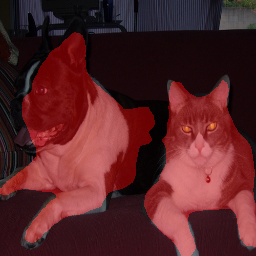

In [12]:
test_image = 'test/origin/2007_001763.jpg'
img = cv2.imread(test_image, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (256, 256))

img_tensor = transform(Image.open(test_image))
img_tensor=img_tensor.unsqueeze(0).to("cuda")
output = fcn_model(img_tensor)
mask = torch.argmax(output, dim=1, keepdim=True)

mask_np = mask.to("cpu").detach().squeeze().numpy()
mask_np = np.array(mask_np*255, dtype=np.uint8)
overlay=cv2.cvtColor(mask_np, cv2.COLOR_GRAY2RGB)
overlay[:,:,0]=0
overlay[:,:,1]=0
overlay_image = cv2.addWeighted(resized_img, 0.6, overlay, 0.4, 0, overlay)
cv2_imshow(overlay_image)

학습 데이터로 제공된 것이 아닌, 다른 고양이 이미지를 찾아서 직접 실험해볼 수 있다. 
- 고양이 이미지를 'catimg.jpg'로 저장
- 좌측의 파일 탭에서 'catimg.jpg' 파일을 업로드
- 아래 블록의 코드를 실행 

In [13]:
test_image = 'catimg.jpg'
img = cv2.imread(test_image, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (256, 256))

img_tensor = transform(Image.open(test_image))
img_tensor=img_tensor.unsqueeze(0).to("cuda")
output = fcn_model(img_tensor)
mask = torch.argmax(output, dim=1, keepdim=True)

mask_np = mask.to("cpu").detach().squeeze().numpy()
mask_np = np.array(mask_np*255, dtype=np.uint8)
overlay=cv2.cvtColor(mask_np, cv2.COLOR_GRAY2RGB)
overlay[:,:,0]=0
overlay[:,:,1]=0
overlay_image = cv2.addWeighted(resized_img, 0.6, overlay, 0.4, 0, overlay)
cv2_imshow(overlay_image)

error: ignored

## **2.Torchvision을 이용한 Computer Vision**



### 2.1 Torchvision 패키지
- Torchvision은 pytorch를 이용해 computer vision 문제를 다루기 위하여 데이터셋, 신경망 구조, 그리고 이미지의 변환 기법 등 유용한 tool을 제공하는 package이다.

- 이번 문제에서는 torchvision 패키지를 사용해보고, torchvision 패키지에서 제공하는 사전학습된 모델을 이용해 object detection과 semantic segmentation을 직접 수행해 본다. 

실험에 사용하기 위한 데이터셋을 다운로드 한다.
  - Object detection을 위한 COCO 데이터셋의 validation 셋
  - Semantic segmentation을 위한 Pascal VOC 데이터셋

In [14]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip

!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

!rm *.zip

--2020-11-13 11:36:34--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.89.11
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.89.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  88.0MB/s    in 2.7s    

2020-11-13 11:36:37 (88.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

--2020-11-13 11:36:37--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.17.236
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.17.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  60.1MB/s    in 9

In [15]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

!tar -xf VOCtrainval_11-May-2012.tar

!rm *.tar

--2020-11-13 11:37:17--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  15.3MB/s    in 2m 8s   

2020-11-13 11:39:25 (14.9 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



  - `torchvision.transforms`를 이용해 이미지의 크기 변화, 회전, crop, normalize 등 다양한 전처리와 data augmentation을 적용할 수 있다. 
  - `torchvision.datasets`을 이용해 MNIST, CIFAR10, CIFAR100, ImageNet, COCO, VOC, SBD 등 vision 분야에서 자주 이용되는 데이터셋을 다운로드 하고 이용할 수 있다.
  - `torchvision.models`를 이용해 VGG, ResNet, FCN, Deeplab, Faster R-CNN, Mask R-CNN 등 vision 분야에서 자주 이용되는 신경망 모델을 이용하고, 사전학습된 모델을 다운로드하여 사용할 수 있다. 
  - 이외에도 computer vision 문제를 다루는 데 유용한 다양한 tool을 제공한다. 

In [16]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms


transform = transforms.Compose([
        transforms.RandomCrop(512), # 데이터의 일부를 crop
        transforms.RandomHorizontalFlip(), # 이미지를 random하게 상하 반전
        transforms.ToTensor(), # 이미지를 tensor로 변환
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]), # 주어진 mean과 std를 이용해 이미지를 normalize
        ]) # Torchvision을 이용한 이미지 전처리 

test_data = datasets.CocoDetection(root='val2017', annFile='annotations/instances_val2017.json', transform= transform) # 데이터셋을 다음과 같이 불러올 수 있다.
model = models.detection.fasterrcnn_resnet50_fpn() # torchvision에 정의된 신경망 구조를 불러올 수 있다. 

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


### 2.2 Torchvision을 이용한 사전학습 모델 활용  

Torchvision과 torchvision에서 제공하는 사전학습된 모델을 이용해 Object Detection을 수행한다. 
  - 이번 실험에서는 Object Detection을 위해 Faster R-CNN 모델을 이용한다.
  - Faster R-CNN 모델의 feature extractor로 ResNet 50 구조를 이용한다. 

In [17]:
detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size = 800).to("cuda").eval() #pretrained argument에 True를 입력하여 사전학습된 모델을 불러올 수 있다. 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Object Detection을 수행하고 그 결과를 visualize하기 위한 함수를 다음과 같이 선언한다.

In [18]:
coco_categories = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
] # COCO에서 제공하는 물체의 목록 
np.random.seed(2020)
COLORS = np.random.uniform(0, 255, size=(len(coco_categories), 3)) # 물체별로 random하게 다른 색을 배정한다. 

def detect(image, model, device, detection_threshold): 
  transform = transforms.ToTensor()
  image = transform(image)
  image = image.to(device)
  image = image.unsqueeze(0) 
  outputs = model(image) # 이미지를 전처리하여 모델로부터 dictionary 형태로 출력되는 추론 결과를 획득한다. 

  pred_classes = [coco_categories [i] for i in outputs[0]['labels'].cpu().numpy()] # 추론 결과의 'labels' item으로부터 이미지 내에 존재하는 class의 목록을 획득한다. 

  pred_scores = outputs[0]['scores'].detach().cpu().numpy() # 추론 결과의 'scores' item으로부터 추론 결과의 confidence score를 획득한다. 
  pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy() # 추론 결과의 'boxes' item으로부터 물체가 위치한 bounding box의 위치를 획득한다. 
  boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32) # Confidence가 일정 기준 이상인 bounding box를 선별한다. 
  return boxes, pred_classes, outputs[0]['labels']


def draw_boxes(boxes, classes, labels, image):
  # read the image with OpenCV
  for i, box in enumerate(boxes):
      color = COLORS[labels[i]] # bounding box에 대응하는 클래스에 배정된 색의 정보를 획득한다. 
      cv2.rectangle(
          image,
          (int(box[0]), int(box[1])),
          (int(box[2]), int(box[3])),
          color, 2
      ) # 획득한 색을 이용해 bounding box를 주어진 이미지 위에 표시한다. 
      cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                  lineType=cv2.LINE_AA) # bounding box 내의 물체의 class를 이미지 위에 text로 표시한다.
  return image

다음과 같이 Object Detection을 수행하고 결과를 visualize한다. 

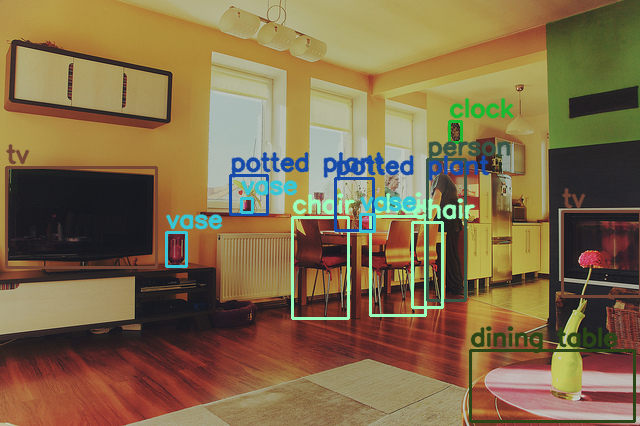

In [19]:
test_image = 'val2017/000000000139.jpg' # COCO 데이터셋의 validation 셋으로부터 임의의 이미지를 선택하였다. 
img = cv2.imread(test_image, cv2.IMREAD_COLOR) # 이미지를 open CV 패키지를 이용해 읽어온다. 

boxes, classes, labels = detect(img, detection_model, 'cuda', 0.8) 
image = draw_boxes(boxes, classes, labels, img)# 추론 결과를 획득하고 visualize한다. 
cv2_imshow(image)

Torchvision과 torchvision에서 제공하는 사전학습된 모델을 이용해 Semantic Segmentation을 수행한다. 
  - 이번 실험에서는 Semantic Segmentation을 위해 Deeplab V3 모델을 이용한다.
  - Deeplab V3 모델의 feature extractor로 ResNet 50 구조를 이용한다. 

In [20]:
segmentation_model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval().to('cuda') #pretrained argument에 True를 입력하여 사전학습된 모델을 불러올 수 있다. 

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


Semantic segmentation을 수행하고 그 결과를 visualize하기 위한 함수를 다음과 같이 선언한다.

In [21]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]) 
# VOC 데이터셋의 각 클래스에 특정한 색을 할당한다.
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  # 각 클래스에 해당하는 픽셀에 정해진 색의 rgb 수치를 입력한다. 
  rgb = np.stack([r, g, b], axis=2)
  return rgb

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.486, 0.456, 0.406], std= [0.229, 0.224, 0.225])
                                ])

def segment(image, model, device):
  # Segmentation을 수행하고, 서로 다른 물체가 서로 다른 색으로 표현된 segmentation mask를 획득한다.  
  image = transform(image)
  image = image.to(device)
  image = image.unsqueeze(0)
  outputs = model(image)['out']
  output_map = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(output_map)
  return rgb


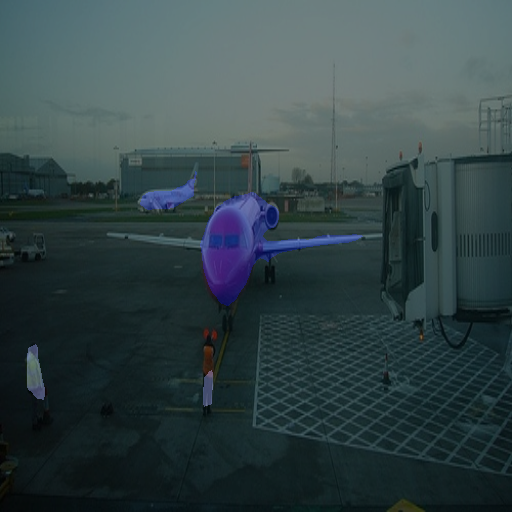

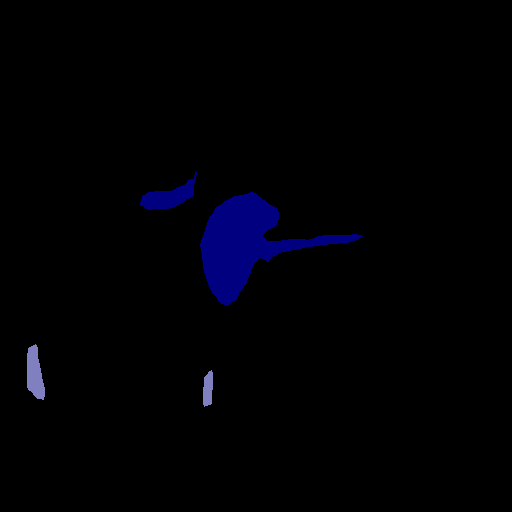

In [22]:
test_image = 'VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg' # VOC 데이터셋으로부터 임의의 이미지를 선택하였다. 
img = cv2.imread(test_image, cv2.IMREAD_COLOR)
resized_img = cv2.resize(img, (512, 512)) # 이미지를 open CV 패키지를 이용해 읽어오고 resize한다. 
#추론 결과를 획득하고 visualize한다.
segmap = segment(resized_img, segmentation_model, 'cuda')
overlay_img = cv2.addWeighted(resized_img, 0.5, segmap, 0.5,0) # 추론 결과를 image와 overlap하여 visualize한다. 
cv2_imshow(overlay_img) # 추론 결과를 image와 overlap하여 visualize한다. 
cv2_imshow(segmap) # 추론 결과를 visualize한다. 

## **3. Neural Style Transfer**
- Style transfer는 한 이미지의 style을 다른 이미지의 style로 변환시키는 문제를 말한다.
- 한 이미지의 내용 (content)와 다른 이미지의 style을 갖는 새로운 이미지를 생성한다.
  - 생성할 이미지의 content를 나타내는 content image와 생성할 이미지의 style을 나타내는 style image의 두 이미지를 입력으로 받는다.
- Neural style transfer는 Neural network를 이용해 style transfer를 수행하는 것을 의미한다.
  - Content image와 style image를 이용한다.
  - 생성하고자 하는 이미지를 임의로 initialize하여 신경망의 input image로 사용한다.
  - Back propagation과 gradient descent를 이용해 신경망의 파라미터가 아닌 입력 이미지를 업데이트 한다. 
- Neural style transfer 과정에서 loss로 사용될 두 종류의 거리 지표를 정의한다.
 - $D_C(X,C)$ : input image(X)와 content image(C) 사이에 content가 얼마나 차이가 있는지 측정한다.
 - $D_S(X,S)$ : input image(X)와 style image(S)사이에 style이 얼마나 차이가 있는지 측정한다.
 - 두 종류의 거리 $D_C, D_S$를 동시에 최소화하는 것을 통해 content image의 content와 style image의 style을 갖는 이미지를 생성할 수 있다.

실험에 사용할 package를 import하고, 실험에 사용할 device를 지정한다.

In [23]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

#CPU 대신에 GPU사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.1 데이터 및 사전학습된 CNN 불러오기 

실험에 사용할 content image와 style image를 다운로드 하고, 적절한 전처리를 수행한다. 

In [24]:
# Download style image
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg 
# Download content image
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg 

--2020-11-13 11:40:14--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.004s  

2020-11-13 11:40:14 (30.2 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2020-11-13 11:40:14--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0s      

2020-11-13 11:40:14 (97.9 MB/s) - ‘dancing.jpg’ saved [40484/40484]



In [25]:
imsize = 512 if torch.cuda.is_available() else 128  # 실험의 효율을 위해, 사용하는 device에 따라 이미지의 크기를 다르게 조정한다. 

loader = transforms.Compose([
    transforms.Resize(imsize),  # 입력 이미지의 크기를 변환한다.
    transforms.ToTensor()])  # PIL 이미지를 tensor로 변환한다. 


def image_loader(image_name):
    image = Image.open(image_name) 
    image = loader(image).unsqueeze(0) # 신경망의 입력 크기를 맞추기 위해, batch에 대응하는 dimension을 추가한다. 
    return image.to(device, torch.float)

style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
# Content image와 style image가 동일한 크기를 갖도록 강제한다.   

이미지를 tensor로 변환하는 과정에서 이미지의 픽셀 값이 0과 1사이의 값을 갖도록 normalize가 이루어진다. 

In [26]:
print(style_img.max())
print(style_img.min())

tensor(0.8706, device='cuda:0')
tensor(0.0118, device='cuda:0')


변환한 Tensor를 다시 PIL 이미지로 변환하여 다음과 같이 visualize할 수 있다. 

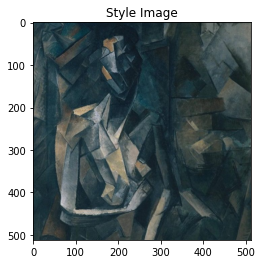

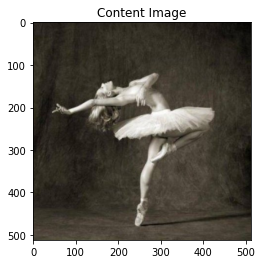

In [27]:
unloader = transforms.ToPILImage() 
plt.ion() #이미지를 갱신한다.

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # Tensor의 값에 변화가 적용되지 않도록 Tensor를 복제한다.
    image = image.squeeze(0)      # 임의로 삽입한 batch dimension을 제거한다. 
    image = unloader(image)       # Tensor를 PIL image로 변환한다.
    plt.imshow(image)             # Image를 visualize한다. 
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 이미지의 visualize 결과가 나타날 수 있도록 잠시 정지한다. 


plt.figure()
imshow(style_img, title='Style Image') # Style image를 visualize한다. 

plt.figure()
imshow(content_img, title='Content Image')  # Content image를 visualize한다. 

Neural style transfer에서는 이미지의 특성을 학습한 CNN 모델을 이용해 이미지의 content distance와 style distance를 획득한다.
  - 일반적으로 이미지의 분류를 위해 사전학습된 CNN 모델이 활용된다.
  - 이번 실험에서는 ImageNet에서 사전학습된 VGG19 신경망을 이용한다.

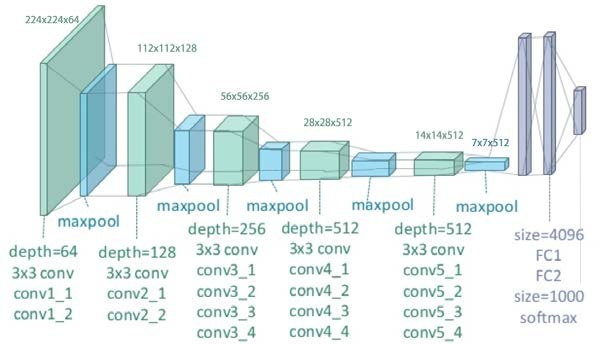 [[그림 출처]](https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356)

 - VGG19 신경망은 위의 그림과 같이 2D convolution layer, MaxPooling layer, fully connected layer로 이루어져 있다. 
  - 이 가운데 fully connected layer는 분류를 위한 부분으로 분류되어, 이번 실험에서는 사용하지 않는다.
  - Neural style transfer에는 이미지로부터 특징(feature)를 추출하는 특징 추출기 (feature extractor)가 활용된다.


In [28]:
cnn = models.vgg19(pretrained=True).features.to(device).eval() #사전 학습된 VGG19 모델의 feature extractor를 device로 보내고, 평가 모드로 세팅한다. 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


- 실험에 사용할 VGG19 신경망은 mean=[0.485, 0.456, 0.406]와 std=[0.229, 0.224, 0.225]를 이용해 normalize된 이미지를 이용해 학습하였으므로, 동일한 mean과 std를 이용해 normalize를 수행한다. 

In [29]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 입력 이미지를 정규화하는 모듈을 만들어 사용한다.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1) # view (텐서의 모양을 바꾸는 함수)를 이용해 mean과 std tensor의 형태를 바꾸어 normalize 과정에서 바로 이용할 수 있도록 한다. 
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # img의 값을 정규화(normalize)한다.
        return (img - self.mean) / self.std

### 3.2 Content loss 및 Style loss 정의하기
- Style Transfer는 content distance $D_C(X,C)$와 style distance $D_S(X,S)$를 동시에 최소화하는 것을 통해 이루어진다.
- 이를 위해 우선 content distance $D_C(X,C)$를 정의한다. 
$$D_{C}^{L}(X, C)=\left\|F_{X L}-F_{C L}\right\|^{2}=\sum_{i}\left(F_{X L}(i)-F_{C L}(i)\right)^{2}$$
  - $F_{X L}$은 input image $X$가 CNN을 통과하는 과정에서 깊이 레벨 L에서 얻어지는 특징 맵 (feature map)을 의미한다.  
  - 마찬가지로, $F_{C L}$은 content image $C$이 CNN을 통과하는 과정에서 깊이 레벨 L에서 얻어지는 특징 맵 (feature map)을 의미한다.  
  - 아래 그림과 같이 입력 이미지가 CNN을 통과하는 과정에서 각각의 layer들로부터 서로 다른 특징 맵들을 획득할 수 있다.

  - $F_{XL}$는 단일 벡터 형태로 나타나며, $F_{XL}(i)$는 $F_{XL}$의 $i$번째 요소를 뜻한다.
  - Input image $X$와 content image $C$ 사이의 거리는 $X$가 입력일 때의 특징 맵 $F_{XL}$과 $C$가 입력일 때의 특징 맵 $F_{CL}$사이의 평균 제곱 오차(MSE, Mean Square Error)로 계산된다.

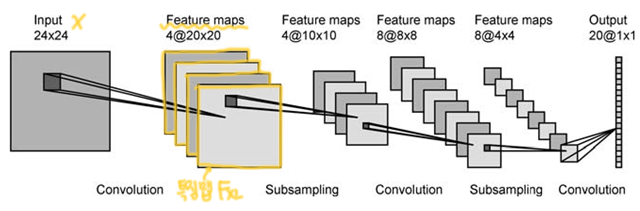 [[그림 출처]](https://intellipaat.com/community/2810/convolutional-neural-network-how-to-get-the-feature-maps)






- 위와 같은 $D_{C}^{L}(X, C)$를 content loss로 정의하고, 이를 계산하기 위한 추가 모듈인 ContentLoss layer를 신경망에 추가한다. 
  - ContentLoss layer는 신경망에서 input image $X$를 받았을 때, 레이어 $L$에서 특징 맵 $F_{XL}$을 가져와서 input image $X$와 content image $C$ 사이의 weighted content distance $w_{CL} \cdot D^L_C(X,C)$를 반환한다. 
  - Input image $X$가 입력되었을 때 이미 content image의 특징 맵 $F_{CL}$이 계산되어 있어야 하므로, ContentLoss layer의 생성 과정에서 $F_{CL}$를 입력으로 받아 detach 메소드를 사용해 gradient 계산에 사용되지 않도록 한다.
  - ContentLoss layer의 forward 메소드를 통해 content loss를 계산하고, 신경망의 연산 과정에 ContentLoss layer가 영향을 미치지 않도록 layer의 input을 그대로 반환한다. 이 과정을 거치면 autograd를 통해 content loss의 gradient 계산을 수행할 수 있다. 


In [30]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 그라디언트를 동적으로 계산하는 데 사용되는 트리에서 대상 콘텐츠를 분리. 이 값은 변수(variable)가 아니라 명시된 값(stated value)이다.
        self.target = target.detach() #레이어를 생성할 때 content image를 입력으로 받아서 F_CL를 미리 계산해놓는다. self.target이 F_CL이다.

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        #input이 F_XL이고, self.target이 F_CL이다. 
        #input image X가 들어오면 F_XL과 F_CL 사이의 MSE를 계산해서 self.loss에 넣는다.
        #self.loss가 content loss(=content 거리)이다.
        return input #Contentloss는 투명 레이어이므로, 입력을 다시 반환한다.

- 다음으로, style distance  $D_S(X,S)$을 정의한다.
$$G_{X L}(k, l)=\left\langle F_{X L}^{k}, F_{X L}^{l}\right\rangle=\sum_{i} F_{X L}^{k}(i) \cdot F_{X L}^{l}(i)$$
$$D_{S}^{L}(X, S)=\left\|G_{X L}-G_{S L}\right\|^{2}=\sum_{k, l}\left(G_{X L}(k, l)-G_{S L}(k, l)\right)^{2}$$
- Gram matrix $G_{X L}(k, l)$은 input image $X$가 신경망을 통과할 때 깊이 레벨 $L$에서 $k$번째 특징 맵과 $l$번째 특징 맵 사이의 상관 관계를 의미한다.
- Input image $X$와 style image $S$ 사이의 style distance $D_S(X,S)$는 이 상관관계 행렬 사이의 평균 제곱 오차(MSE, Mean Square Error)로 나타낼 수 있다.

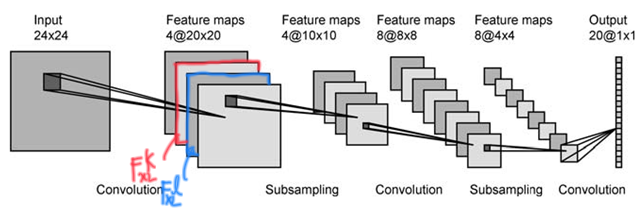

- Gram matrix $G_{X L}(k, l)$는 특징 맵($F_{X L}$)과 그 특징맵을 transpose 한 행렬을 곱하는 것으로 획득할 수 있다.
  - 계산을 위해서 [a,b,c,d] size의 4차원 텐서인 feature map을 [a * b, c * d] size의 2차원 matrix로 바꾸어, feature map의 한 channel을 하나의 row로 벡터화한다. 
  - 마지막으로, 각 layer 별 feature의 개수의 차이를 보정하기 위해 전체 feature의 개수인 (a * b * c * d) 값으로 계산된 행렬을 나누어 normalization한다. 이를 통해 feature의 수가 많은 첫번째 layer가 gradient descent 과정에서 너무 큰 영향을 미치는 것을 방지할 수 있다. 

In [31]:
def gram_matrix(input):
    a, b, c, d = input.size()
    # a는 batch size (=1), b는 feature map들의 갯수(channel의 수) 이다 (위 그림에서 b=4). 
    # (c,d) 는 feature map의 높이와 넓이이다. (위 그림에서 c = d = 20)

    features = input.view(a * b, c * d)  # feature map의 각 channel을 row로 벡터화시킨다.

    G = torch.mm(features, features.t())  # feature map들 사이의 상관관계 행렬을 구한다.

    return G.div(a * b * c * d)  # 계산된 matrix G를 전체 feature의 개수로 나누어 normalize 한다.

- Content loss와 마찬가지로 $D_S(X,S)$를 style loss로 정의하고, 이를 계산하기 위한 추가 모듈인 StyleLoss layer를 신경망에 추가한다. 
  - StyleLoss layer의 생성 과정에서는 style image의 gram matrix $G_{SL}$을 입력으로 받는다.
  - Style matrix의 forward 메소드를 통해 gram matrix 사이의 MSE loss로 style loss를 계산하고, ContentLoss layer와 마찬가지로 layer의 input을 그대로 반환한다.

In [32]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() #style image의 gram matrix를 계산한다.

    def forward(self, input):
        G = gram_matrix(input) #input image의 gram matrix를 계산한다.
        self.loss = F.mse_loss(G, self.target) #style loss(=style 거리)를 구한다.
        return input

- 정의한 ContentLoss layer와 Styleloss layer를 VGG 모델의 각 convolution layer의 바로 다음에 추가하여 이용한다.
  - Content loss는 4번째 convolution layer에서만 계산한다.
  - Style loss는 모든 convolution layer에 대해 계산한다.

In [33]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    #vgg19를 복사한다.
    cnn = copy.deepcopy(cnn) 

    # 표준화(normalization) 모듈
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # loss값을 저장하기 위한 list를 선언한다.
    content_losses = []
    style_losses = []

    # nn.Sequential을 이용해 순차적으로 신경망 layer와 loss layer를 모델에 추가한다.
    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d): #Conv2d layer
            i += 1 # conv레이어를 찾을때마다 값을 증가
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU): #ReLU layer
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d): #MaxPool2d layer
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d): #BatchNorm2d layer
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer) #레이어를 추가함.

        #layer가 content_layers 중에 하나라면 ContentLoss layer를 추가한다:
        if name in content_layers:
            target = model(content_img).detach() 
            content_loss = ContentLoss(target) #content_img를 지금까지 만든 model에 넣어서 conteng image의 feature map을 계산한다.
            model.add_module("content_loss_{}".format(i), content_loss) #ContentLoss layer를 추가한다.
            content_losses.append(content_loss)

        #layer가 style_layers 중에 하나라면 StyleLoss layer를 추가한다:
        if name in style_layers:
            target_feature = model(style_img).detach() 
            style_loss = StyleLoss(target_feature) #style_img를 지금까지 만든 model에 넣어서 style image의 gram matrix를 계산한다.
            model.add_module("style_loss_{}".format(i), style_loss) #StyleLoss layer를 추가한다.
            style_losses.append(style_loss)

    # 마지막 ContentLoss 또는 StyleLoss 이후의 layer들을 제거한다.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### 3.3 Gradient Descent를 이용한 Style Transfer

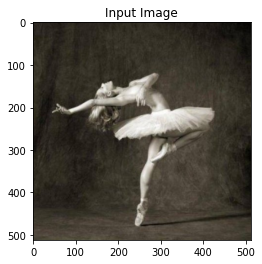

In [34]:
#content 이미지를 복사해서 입력 이미지로 사용한다.
input_img = content_img.clone()

# 원본 입력 이미지를 출력.
plt.figure()
imshow(input_img, title='Input Image')

- L-BRGS 알고리즘을 이용해 gradient descent를 수행한다. 
  - 기존의 신경망 학습 예제와는 달리, input image를 업데이트 해야 하므로 `input_img`를 optimizer의 파라미터로 입력하여 gradient descent를 수행한다. 

In [35]:
def get_input_optimizer(input_img):
    #input image 자체를 업데이트가 필요한 파라미터로 입력한다.
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

- Style transfer를 수행할 함수 `run_style_transfer`를 다음과 같이 정의한다. 
  - 매 loop에서 loss를 계산하여 input image를 업데이트한다.
  - 업데이트한 input image를 다음 루프에서 다시 입력으로 이용한다.
  - L-BFGS 알고리즘을 이용해 파라미터를 업데이트 하는 과정에서 함수를 여러번 다시 계산할 수 있도록 `closure`라는 함수를 정의하여 이용한다.
    - `closure`함수는 gradient를 0으로 만들고, 해당 지점에서 loss를 계산하여 반환한다.
    - 정의된 `closure` 함수는 `optimizer.step(closure)`와 같이 파라미터 업데이트 코드의 argument로 사용된다.

In [36]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    
  
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)   #get_style_model_and_losses를 이용해 model, style_losses, content_losses를 구한다.
    optimizer = get_input_optimizer(input_img)     #get_input_optimizer를 이용해 input image를 업데이트 시키는 optimizer를 정의한다.


    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 업데이트된 input image의 픽셀 값들을 0과 1 사이로 보정한다.
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            #각 layer에서 획득한 loss들을 합산한다.
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            #style_score와 content_score의 비중을 비슷하게 하기 위해 입력받은 가중치를 곱해서 합산한다.
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score #style loss와 content loss를 더한 값을 최종 loss로 사용한다.

        optimizer.step(closure)

    # 마지막으로 업데이트된 input image의 픽셀 값들을 0과 1 사이로 보정한다.
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


run [50]:
Style Loss : 4.183412 Content Loss: 4.273358

run [100]:
Style Loss : 1.148577 Content Loss: 3.051185

run [150]:
Style Loss : 0.723271 Content Loss: 2.664213

run [200]:
Style Loss : 0.487392 Content Loss: 2.507165

run [250]:
Style Loss : 0.360057 Content Loss: 2.420557

run [300]:
Style Loss : 0.274423 Content Loss: 2.366078



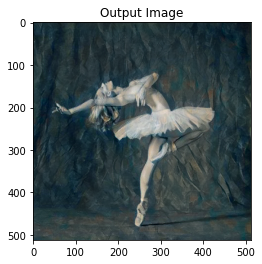

In [37]:
#정의한 run_style_transfer 함수를 이용해 변환된 output image를 획득한다.
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

##**4.Reference**
https://pytorch.org/docs/stable/_modules/torchvision/models/segmentation/segmentation.html#fcn_resnet50

https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

https://colab.research.google.com/github/spmallick/learnopencv/blob/master/PyTorch-Segmentation-torchvision/intro-seg.ipynb#scrollTo=5GA_GNohUHnR

